In [1]:
import torch
import tiktoken
import matplotlib.pyplot as plt
from basic import create_dataloader_v1
from GPT_architecture import GPTModel
from GPT_architecture import Generate_text

In [2]:
GPT_CONFIG_124M = {
        "vocab_size": 50257,
        "context_length": 256, # Shortened from 1024 to make it easier to train on a laptop
        "emb_dim": 768,
        "n_heads": 12,
        "n_layers": 12,
        "drop_rate": 0.1,
        "qkv_bias": False
}

In [3]:
def text_to_token_ids(txt, tokenizer):
    encoded= tokenizer.encode(txt, allowed_special={'<|endoftext|>'})
    encoded_tensor= torch.tensor(encoded).unsqueeze(0) # add dimension at position 0
    return encoded_tensor

In [4]:
def token_ids_to_txt(token_ids, tokenizer):
    flat= token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist())

In [5]:
def cross_entropy(input_batch, target_batch, model, device, num_batches=None):
    input_batch= input_batch.to(device)
    target_batch= target_batch.to(device)
    logits= model(input_batch)
    loss= torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [6]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss=0
    if len(data_loader)==0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches= min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss= cross_entropy(input_batch, target_batch, model, device)
            total_loss+=loss.item()
        else:
            break
    return total_loss/num_batches

In [7]:
def evaulate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # to stop dropout
    # no grad to stop gradient calculation 
    with torch.no_grad(): 
        train_loss= calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss= calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [8]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size= model.pos_emb.weight.shape[0]
    encoded= text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids= Generate_text(model= model, idx= encoded, max_new_tokens=50, context_size=context_size)
        decoded_text= token_ids_to_txt(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
    model.train()

In [9]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_fr, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen= [], [], []
    tokens_seen, global_step= 0,-1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
         optimizer.zero_grad()
         loss = cross_entropy(input_batch, target_batch, model, device)
         loss.backward()
         optimizer.step()
         tokens_seen+=input_batch.numel()
         global_step+=1

         if global_step % eval_fr ==0:
            train_loss, val_loss = evaulate_model(model, train_loader, val_loader, device, eval_iter)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            track_tokens_seen.append(tokens_seen)
            print(f"Ep{epoch+1}(Step {global_step:06d}):"
                  f"Train loss{train_loss:.3f}"
                  f"Val loss{val_loss:.3f}")
        
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [10]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond= idx[:, -context_size:]
        with torch.no_grad():
            logits= model(idx_cond)
        logits= logits[:,-1,:]
        if top_k is not None:
            top_logits, _=torch.topk(logits, top_k)
            min_val= top_logits[:,-1]
            logits= torch.where(
                logits<min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits= logits/temperature
            probs= torch.softmax(logits, dim=-1)
            idx_next= torch.multinomial(probs, num_samples=1)
        else:
            idx_next= torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx= torch.cat((idx, idx_next), dim=1)
    return idx

In [11]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

Output text every effort moves you rentingetic minion mobilized Macicone heterogeneity achaRAM
Probability received for next word: torch.Size([2, 3, 50257])
Token IDs: tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Target batch 1:  effort moves you
Output batch 1: Armed heNetflix
Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9836e-05, 1.6783e-05, 4.7559e-06])
Log_probas: tensor([ -9.5042, -10.3796, -11.3677, -10.1307, -10.9951, -12.2561])
Average log probas tensor(-10.7722)
Negative acg log probas tensor(10.7722)
Logits shape: torch.Size([2, 3, 50257])
target shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets torch.Size([6])
loss tensor(10.7722)
Perplexity 47678.86328125
Characters: 20480
Tokens 5146
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch

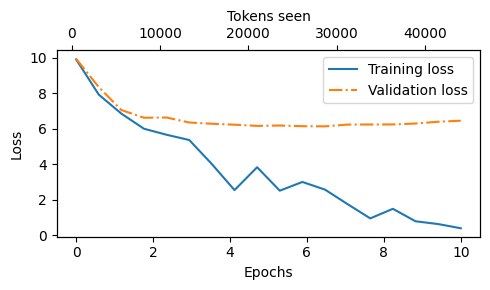

epochs tensor: tensor([ 0.0000,  0.5882,  1.1765,  1.7647,  2.3529,  2.9412,  3.5294,  4.1176,
         4.7059,  5.2941,  5.8824,  6.4706,  7.0588,  7.6471,  8.2353,  8.8235,
         9.4118, 10.0000])
tokens seen: [512, 3072, 5632, 8192, 10752, 13312, 15872, 18432, 20992, 23552, 26112, 28672, 31232, 33792, 36352, 38912, 41472, 44032]
train losses: [9.896516799926758, 7.916933059692383, 6.846530914306641, 5.996530532836914, 5.659334182739258, 5.363016605377197, 4.010303020477295, 2.5487778186798096, 3.833909749984741, 2.5157291889190674, 3.0061287879943848, 2.575078248977661, 1.7569631338119507, 0.9580819606781006, 1.4966765642166138, 0.7955607771873474, 0.638679027557373, 0.4037236273288727]
val losses: [9.932438850402832, 8.338539123535156, 7.0479350090026855, 6.616054058074951, 6.628817558288574, 6.348014831542969, 6.27811336517334, 6.225006580352783, 6.15823221206665, 6.178470611572266, 6.140295028686523, 6.133021354675293, 6.23182487487793, 6.236241340637207, 6.239742279052734, 6.

In [12]:
def main():
    torch.manual_seed(123)
    model= GPTModel(GPT_CONFIG_124M)
    model.eval()

    start_context= "every effort moves you"
    tokenizer= tiktoken.get_encoding("gpt2")
    token_ids= Generate_text(
        model= model,
        idx= text_to_token_ids(start_context, tokenizer),
        max_new_tokens=10,
        context_size=GPT_CONFIG_124M['context_length']
    )
    print("Output text", token_ids_to_txt(token_ids, tokenizer))

    # Calculate loss
    inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                           [40, 1107, 588]])    # "I really like"]
    
    targets = torch.tensor([[3626, 6100, 345],  # [" effort moves you",
                            [588, 428, 11311]]) # " really like chocholate"]
    with torch.no_grad():
        logits= model(inputs)
    probas= torch.softmax(logits, dim=-1)
    print('Probability received for next word:', probas.shape)

    token_ids= torch.argmax(probas, dim=-1, keepdim=True)
    print("Token IDs:", token_ids)

    print(f"Target batch 1: {token_ids_to_txt(targets[0], tokenizer)}")
    print(f"Output batch 1:" f"{token_ids_to_txt(token_ids[0].flatten(), tokenizer)}")

    text_idx=0
    target_probas_1= probas[text_idx, [0,1,2], targets[text_idx]]
    print("Text 1:", target_probas_1)

    text_idx = 1
    target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
    print("Text 2:", target_probas_2)

    log_probas= torch.log(torch.cat((target_probas_1, target_probas_2)))
    print("Log_probas:", log_probas)

    avg_log_probas= torch.mean(log_probas)
    print("Average log probas", avg_log_probas)

    neg_avg_log_probas= avg_log_probas*-1
    print("Negative acg log probas", neg_avg_log_probas)

    print("Logits shape:", logits.shape)
    print("target shape:", targets.shape)

    logits_flat= logits.flatten(0,1)
    targets_flat= targets.flatten()
    print("Flattened logits:", logits_flat.shape)
    print("Flattened targets", targets_flat.shape)

    loss= torch.nn.functional.cross_entropy(logits_flat, targets_flat)
    print("loss", loss)

    perplexity= torch.exp(loss)
    print(f"Perplexity {perplexity}")

    filepath= "the-verdict.txt"
    with open (filepath, 'r', encoding='utf-8') as file:
        text_data= file.read()
    
    total_characters= len(text_data)
    total_tokens= len(tokenizer.encode(text_data))
    print("Characters:", total_characters)
    print("Tokens", total_tokens)

    train_ratio=0.90
    split_idx= int(train_ratio*len(text_data))
    train_data= text_data[:split_idx]
    val_data= text_data[split_idx:]

    torch.manual_seed(123)

    train_loader = create_dataloader_v1(
          train_data,
          batch=2,
          max_len=GPT_CONFIG_124M['context_length'],
          stride=GPT_CONFIG_124M["context_length"],
          drop_last=True,
          shuffle=True,
          num_workers=0
   )

    val_loader = create_dataloader_v1(
            val_data,
            batch=2, # A more common batch size would be 1024, this is just for the demonstration purpose
            max_len=GPT_CONFIG_124M["context_length"],
            stride=GPT_CONFIG_124M["context_length"],
            drop_last=False,
            shuffle=False,
            num_workers=0
    )
    
    # Iterate through the data loaders to check that they were created correctly
    
    print("Train loader:")
    for x, y in train_loader:
        print(x.shape, y.shape)
    
    print("\nValidation loader:")
    for x, y in val_loader:
        print(x.shape, y.shape)
    
    device= torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        train_loss= calc_loss_loader(train_loader, model, device)
        val_loss= calc_loss_loader(val_loader, model, device)
     
    print("Training loss:", train_loss)
    print("Val loss", val_loss)

    # Let's pretrain :)

    torch.manual_seed(123)
    model= GPTModel(GPT_CONFIG_124M)
    model.to(device)
    optimizer= torch.optim.AdamW(
        model.parameters(), lr=0.0004, weight_decay=0.1
    )    
    num_epochs= 10
    print("LET'S TRAIN")
    train_losses, val_losses, tokens_seen= train_model_simple(
        model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_fr=5, eval_iter=1, start_context="Every effort moves you", tokenizer=tokenizer
    )
    epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
    plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
    
    print("epochs tensor:", epochs_tensor)
    print("tokens seen:", tokens_seen)
    print("train losses:", train_losses)
    print("val losses:", val_losses)

    model.to("cpu")
    model.eval()

    tokenizer= tiktoken.get_encoding("gpt2")
    token_ids= Generate_text(model=model, idx= text_to_token_ids("Every effort moves you", tokenizer),
                            max_new_tokens=25,
                            context_size=GPT_CONFIG_124M["context_length"]
                             )
    
    torch.manual_seed(123)
    token_ids = generate(
            model=model,
            idx=text_to_token_ids("Every effort moves you", tokenizer),
            max_new_tokens=15,
            context_size=GPT_CONFIG_124M["context_length"],
            top_k=25,
            temperature=1.4
    )
    print("Output text:\n", token_ids_to_txt(token_ids, tokenizer))
    
    print("Saving the pretrained model")
    torch.save(model.state_dict(), "model.pth")
    
    print("Loading just saved model")
    
    model_loaded = GPTModel(GPT_CONFIG_124M)
    model_loaded.load_state_dict(torch.load("model.pth"))
    model_loaded.eval()
    
    token_ids = generate(
            model=model_loaded,
            idx=text_to_token_ids("It was another Thursday in the office", tokenizer),
            max_new_tokens=15,
            context_size=GPT_CONFIG_124M["context_length"],
            top_k=1,
            temperature=1.,
    )
    print("Output text:\n", token_ids_to_txt(token_ids, tokenizer))
    
    # Saving model together with optimizer to continue training from that step
    
    print("Saving model together with the optimizer now")
    torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        "model_and_optimizer.pth"
    ) 

if __name__ == "__main__":
    main()